<a href="https://colab.research.google.com/github/a-nagar/vistra-beginner/blob/main/Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis

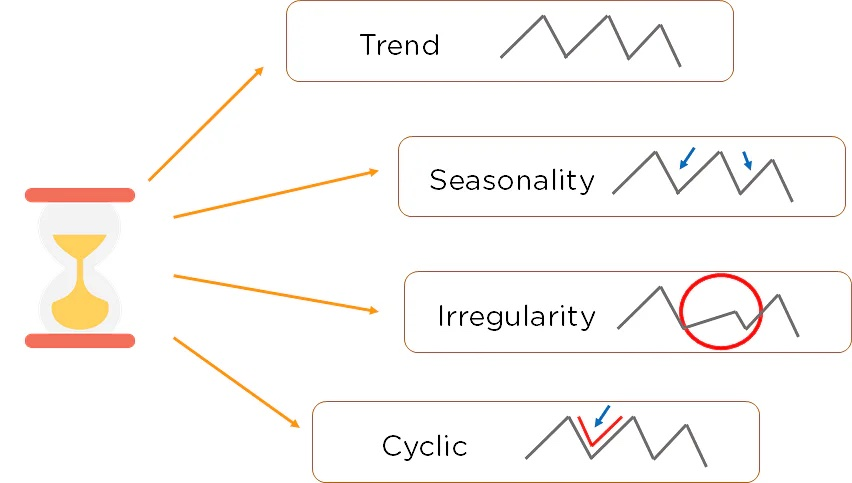

# Time Series Analysis

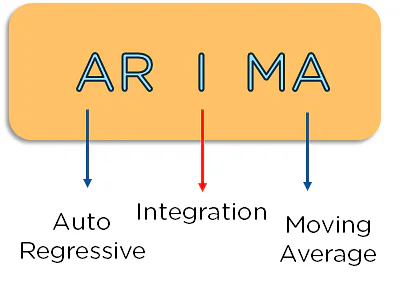

Source: https://www.simplilearn.com/tutorials/python-tutorial/time-series-analysis-in-python

## Auto-Regression:

Current value depends on previous time steps. 

## Moving Average:

Smooths out noise by taking rolling average of previous n days. 

## Integration:

Note that time series analysis is done assuming that the mean of data over time doesn't change. If it does, we need to perform integration. 



The plot on the left shows daily price of Google stock. Note that the mean is not stationary over time. On the right is the differenced version (daily change in prices) of the first graph – meaning that it shows the change in Google stock of 200 days. The differenced version is stationary.

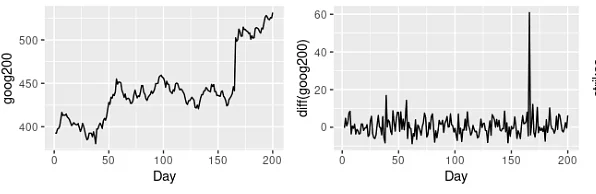

## ARIMA model takes all these factors into account:

**p**: Previous lagged values for each time point. Derived from the Auto-Regressive Model.


**d**: Number of times data is differenced to make it stationary. It is the number of times it performs integration.

**q**: Previous lagged values for the error term. Derived from the Moving Average.


# How to select the best parameters?

Besides trial and error, there are some statistical tests that can help us infer the best value of the parameters.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [ ]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

Let's load the WWWUsage dataset. It represents a time series of the numbers of users connected to the Internet through a server every minute.

https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/WWWusage


In [ ]:
df = pd.read_csv('https://an-utd-python.s3.us-west-1.amazonaws.com/WWWusage.csv', names=['value'], header=0)
print (f"Total samples: {len(df)}")
df

Total samples: 100


,value
1,88
2,84
3,85
4,85
5,84
...,...
96,222
97,228
98,226
99,222


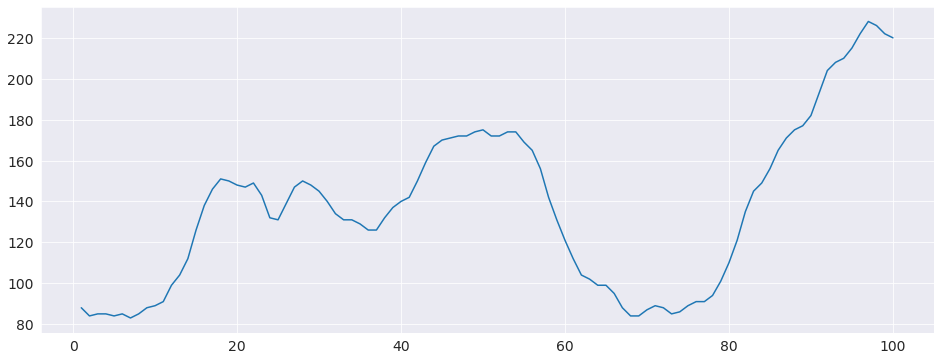

In [ ]:
df['value'].plot()

## Finding the p parameter of ARIMA model

We can inspect the partial autocorrelation plot, which measures the correlation between the time-series data and a certain lag. Based on the presence or absence of correlation, we can determine the lag or order needed.

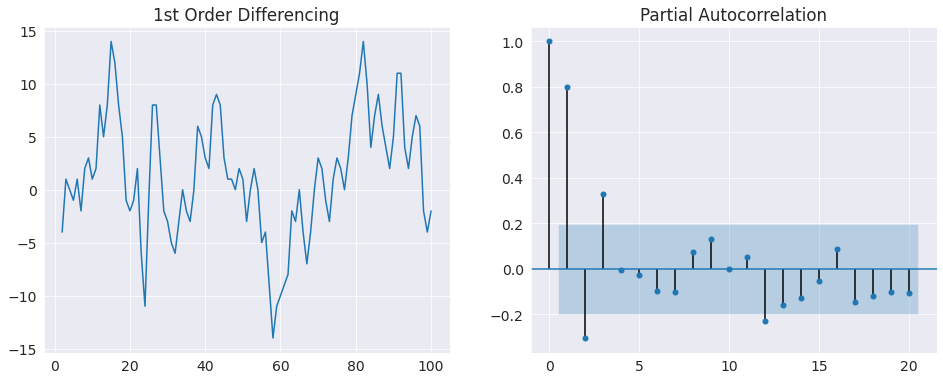

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')
ax1.plot(df.value.diff())

ax2 = f.add_subplot (122)
plot_pacf(df.value.diff().dropna(), ax=ax2)
plt.show()

We see the 1st lag is the most significant. Thus, we consider “p” to be 1.



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -319.942
Date:                Mon, 26 Sep 2022   AIC                            645.883
Time:                        02:20:22   BIC                            653.699
Sample:                             0   HQIC                           649.046
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.7956     54.161      2.784      0.005      44.642     256.949
ar.L1          0.9952      0.018     53.806      0.000       0.959       1.031
sigma2        33.5966      5.079      6.615      0.0

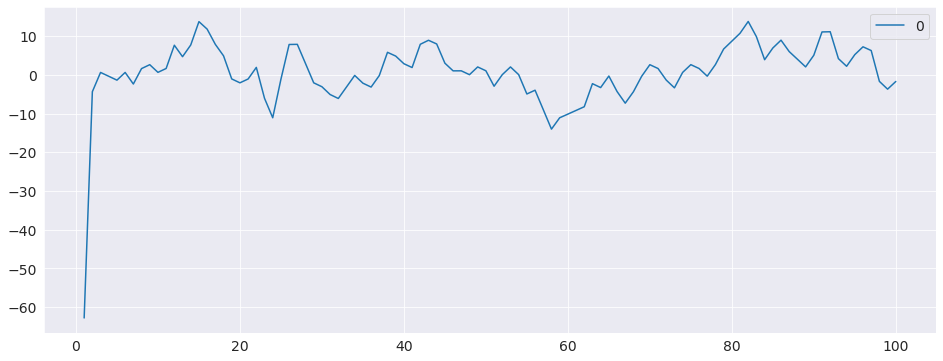

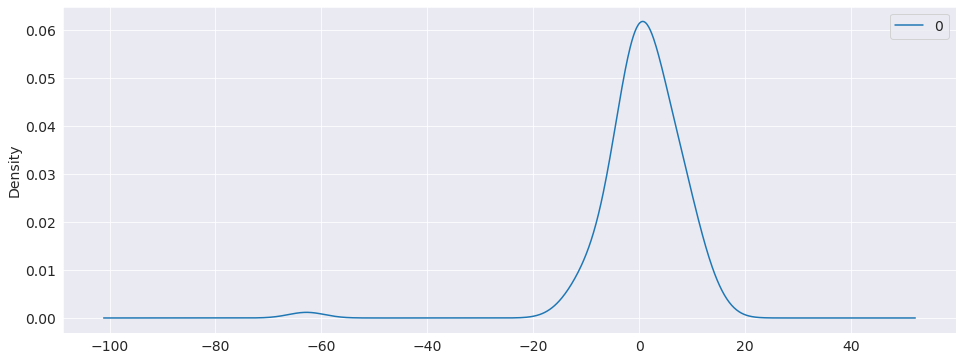

                0
count  100.000000
mean     0.623325
std      8.543711
min    -62.795572
25%     -2.245855
50%      1.093983
75%      5.014092
max     13.857885


In [ ]:
model = ARIMA(df, order=(1,0,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

Note the high residuls and the warning about non-stationary time series. Let's try to make it stationary.

## Finding the d parameter using Auto-Correlation plot

An autocorrelation plot is designed to show whether the elements of a time series are positively correlated, negatively correlated, or independent of each other. 

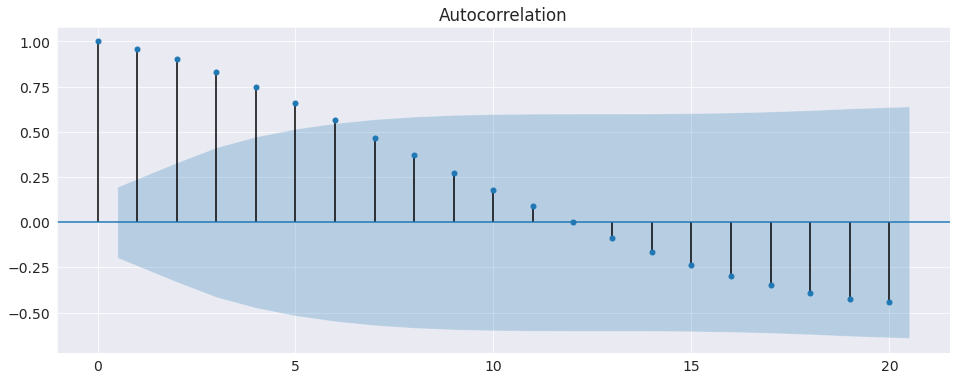

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=20)
plt.show()

The above plot shows significant auto-correlation. Let's take the difference between two values i.e. 1st order difference.

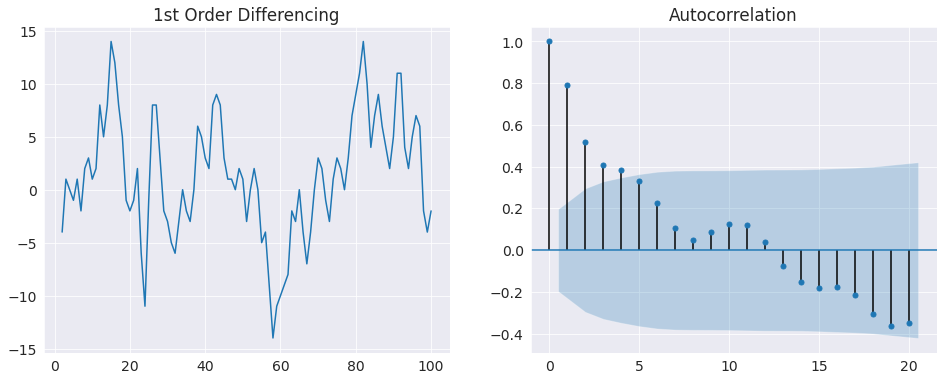

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("1st Order Differencing")
ax1.plot(df.value.diff())

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show()

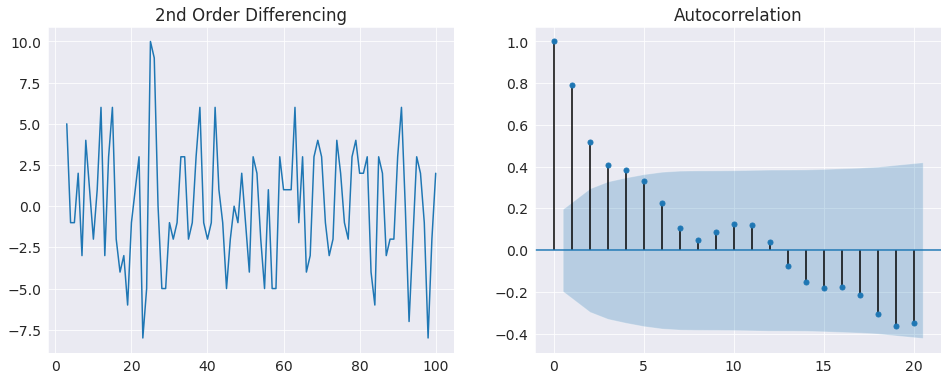

In [ ]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title("2nd Order Differencing")
ax1.plot(df.value.diff().diff())

ax2 = f.add_subplot(122)
plot_acf(df.value.diff().dropna(), ax=ax2)
plt.show()

The ADF test can also be used to calculate the value of d. We would like the p-value of the model to be less than or equal to 0.05 

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.value.dropna())
print('p-value of original : ' , result[1])
result = adfuller(df.value.diff().dropna())
print('p-value of d=1 : ' , result[1])
result= adfuller(df.value.diff().diff().dropna())
print('p-value of d=2: ' , result[1])

p-value of original :  0.12441935447109442
p-value of d=1 :  0.07026846015272728
p-value of d=2:  2.843428755547158e-17


We can accept d = 1 as it's closest to 0.05. Let's try q = 2.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(df.value, order=(1,1,2))
model = arima_model.fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  100
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -254.126
Date:                Mon, 26 Sep 2022   AIC                            516.253
Time:                        02:20:28   BIC                            526.633
Sample:                             0   HQIC                           520.453
                                - 100                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6976      0.130      5.365      0.000       0.443       0.952
ma.L1          0.4551      0.169      2.699      0.007       0.125       0.786
ma.L2         -0.0664      0.157     -0.424      0.6

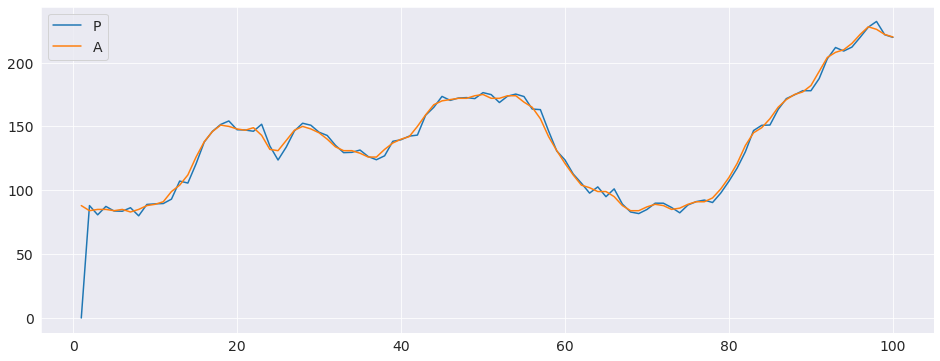

In [ ]:
model.predict().plot()
df['value'].plot()
plt.legend("PA")
plt.show()

# Learning to predict Apple's Stock Price

In [ ]:
import pandas as pd 
import pandas_datareader as web 
import datetime

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 825 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import yfinance as yahooFinance
import pandas as pd
 
 
data = yahooFinance.Ticker("AAPL")
aapl = pd.DataFrame(data.history(period="1y")['Close'])


In [ ]:
aapl.head()

,Close
Date,
2021-09-24,146.101303
2021-09-27,144.559937
2021-09-28,141.119232
2021-09-29,142.034103
2021-09-30,140.711517


In [ ]:
aapl.index

DatetimeIndex(['2021-09-24', '2021-09-27', '2021-09-28', '2021-09-29',
               '2021-09-30', '2021-10-01', '2021-10-04', '2021-10-05',
               '2021-10-06', '2021-10-07',
               ...
               '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15',
               '2022-09-16', '2022-09-19', '2022-09-20', '2022-09-21',
               '2022-09-22', '2022-09-23'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)

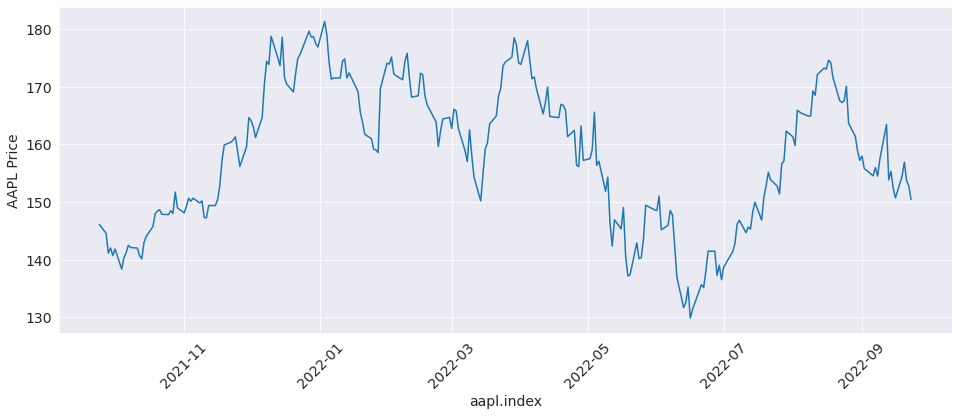

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


plt.ylabel('AAPL Price')
plt.xlabel('aapl.index')
plt.xticks(rotation=45)
plt.plot(aapl.index, aapl['Close'], )

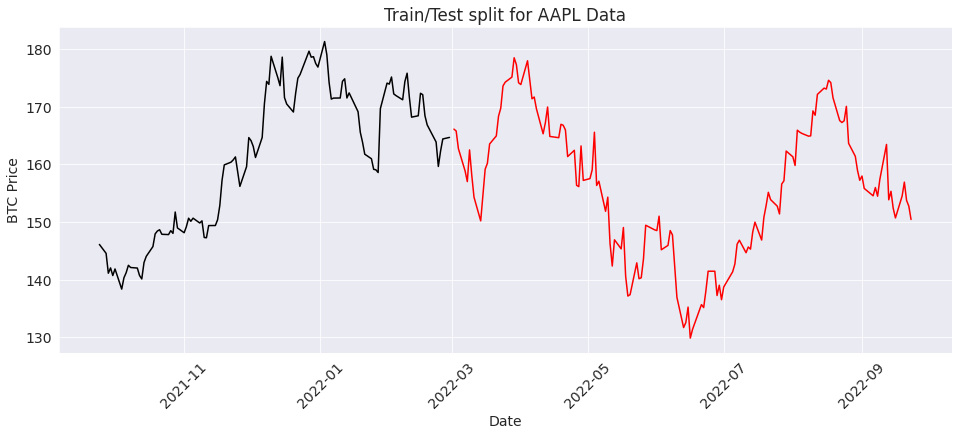

In [ ]:
train = aapl[aapl.index < pd.to_datetime("2022-03-01", format='%Y-%m-%d')]
test = aapl[aapl.index > pd.to_datetime("2022-03-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for AAPL Data")
plt.show()

In [ ]:
test

,Close
Date,
2022-03-02,166.084946
2022-03-03,165.755875
2022-03-04,162.704605
2022-03-07,158.845657
2022-03-08,156.990952
2022-03-09,162.485229
2022-03-10,158.067886
2022-03-11,154.288681
2022-03-14,150.190399


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('

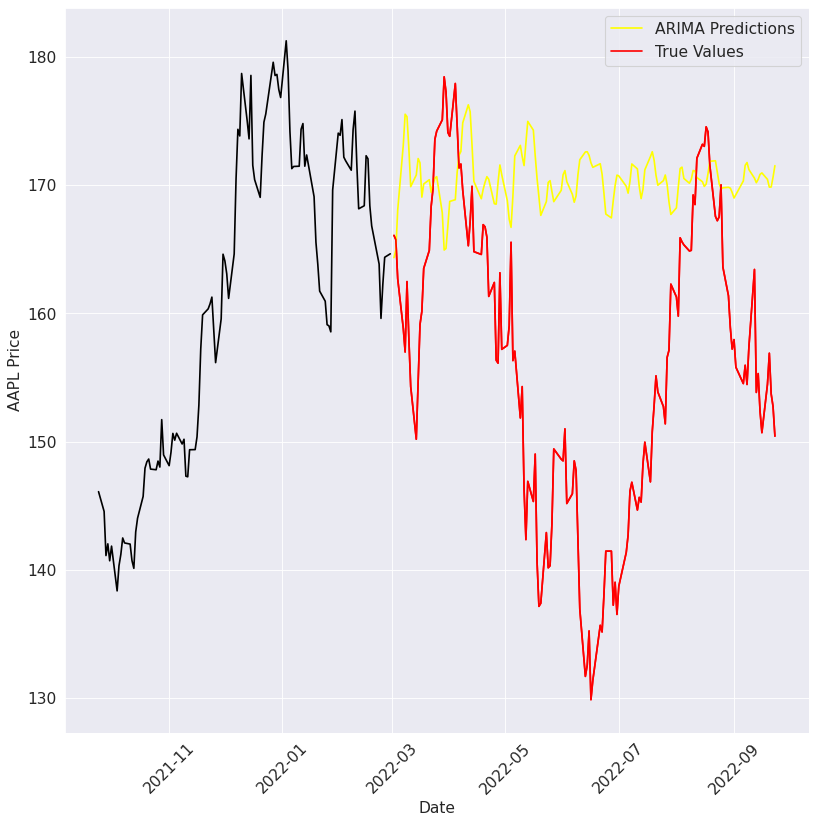

ARIMA RMSE:  18.913655609164888


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)

y = train['Close']


ARIMAmodel = ARIMA(y, order = (50, 1, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('AAPL Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.plot(test['Close'], color = 'Red', label = 'True Values')
plt.legend()
plt.show()



import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["Close"].values, y_pred_df["Predictions"]))
print("ARIMA RMSE: ",arma_rmse)
